In [1]:
import numpy as np
import json
import yaml
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from matplotlib.ticker import MaxNLocator

import xobjects as xo
import xtrack as xt
import xpart as xp

import pymadx
from xcoll_plotting import plot_functions as xcp

No pytransport functionality
No pytransport functionality


In [2]:
# SPECIFIC CONVERSION FUNCTIONS FOR THIS EXAMPLE

def change_coordinates_to_b1(df):
    #df['s_b1'] = np.where(df['s'] <=  end_s-TCCS_loc, end_s-TCCS_loc-df['s'],2*end_s-TCCS_loc-df['s'])
    #df = df.sort_values(by="s_b1")
    df['s_b1'] = end_s - df['s']
    return df


def reset_coord_cry_tracking(df, twiss):
    df['s_b1'] = np.where(df['s'] <=  end_s-TCCS_loc, end_s-TCCS_loc-df['s'], 2*end_s-TCCS_loc-df['s'])
    names = twiss.to_pandas().name.to_numpy()
    idx = np.where(names == TCCS_name)[0][0]
    names = np.roll(names, -idx)
    df['name'] = names
    df = df.sort_values(by="s_b1")


    return df


def extract_channelled(df):
    df = df.loc[(df['s_b1']<end_s-TCCS_loc) & (df['s_b1']>end_s-TCLA_loc)]
    return df

def filter_aperture_rotations(df, line):    
    aperture_offsets = []
    for name, element in line.element_dict.items():
        if '_tilt_entry' in name and element.__class__.__name__.startswith('SRotation'):
            aper_name = name.split('_tilt')[0]
            aperture_offsets.append(aper_name)#[aper_name] = (element.s)

    return df[~df['name'].str.contains('|'.join(aperture_offsets), case=False)]

In [3]:
# STANDARD CONVERSION FUNCTIONS

def _norm_to_geom_emittance(norm_emittance, E0, E):
    betagamma = _calc_betagamma(E0, E)
    return norm_emittance / betagamma

def _calc_betagamma(E0, E):
    gamma = float(E)/E0
    beta = np.sqrt(1.-(1./gamma)**2)
    return beta*gamma

def rad_to_deg(n):
    return n*180/np.pi



In [4]:
# LOAD COLLIMATORS FUNCTIONS

def add_collimator_halfgap(coll_df, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy):
        
    # Calculate the geometric emittances first
    emit_geom_x = _norm_to_geom_emittance(nemitt_x, reference_mass, reference_energy)
    emit_geom_y = _norm_to_geom_emittance(nemitt_y, reference_mass, reference_energy)

    openings = []
    sigmas_x = []
    sigmas_y = []
    for name, parameters in coll_df.iterrows():
        betx = parameters["betx"]
        bety = parameters["bety"]

        nsigma = parameters["gap"]
        angle  = parameters["angle"]

        sigma_x = np.sqrt(betx * emit_geom_x)
        sigma_y = np.sqrt(bety * emit_geom_y)

        a = nsigma * sigma_x
        b = nsigma * sigma_y

        x = a * np.cos(angle)
        y = b * np.sin(angle)

        sigmas_x.append(sigma_x)
        sigmas_y.append(sigma_y)
        openings.append(np.sqrt(x**2 + y**2))

    coll_df['sigma_x'] = sigmas_x
    coll_df['sigma_y'] = sigmas_y
    coll_df['opening'] = openings
    


def load_coll_yaml(filename, optics_df, reference_mass, reference_energy,
                          nemitt_x = 3.5e-6, nemitt_y = 3.5e-6, beam = 2):
    
    # load collimators form yaml file as pandas
    with open(filename, 'r') as file:
           collimators = yaml.safe_load(file)   
    coll_dict  = collimators['collimators'][f'b{beam}']
    df = pd.DataFrame.from_dict(coll_dict, orient="index")
    df = df.rename_axis('name').reset_index()
    coll_list = df['name'].to_list()
    
    # merge it with dataframe from twiss
    df_col_twiss = optics_df[optics_df['name'].isin(coll_list)]
    df_coll_tot = pd.merge(df, df_col_twiss, on="name")
    
    add_collimator_halfgap(df_coll_tot, nemitt_x, nemitt_y, 
                           reference_mass, reference_energy)
    return df_coll_tot

In [5]:
# PLOT APERTURES 

def plot_apertures(ap_limit_df, plot_axis, plane, plot_apertype=False):

    plot_bounds = []
    if 'h' in plane:
        plot_bounds.append(['xmin', 'xmax'])
    if 'v' in plane:
        plot_bounds.append(['ymin', 'ymax'])
        
    for bounds in plot_bounds:
        # dummy plot for label and colour
        label_string = 'Hor. aper' if bounds[0].startswith('x') else 'Ver. aper'
        p = plot_axis.plot([], [], label=label_string) 
        s = ap_limit_df.index.values
        ap_limit_df['s'] = s
        ap_limit_df = change_coordinates_to_b1(ap_limit_df)
        for bound in bounds:
            lim_data = ap_limit_df[bound].values #convert_m_to_mm(ap_limit_df[bound].values)
            p = plot_axis.plot(ap_limit_df['s_b1'], lim_data, c="C7")
            if bound.endswith('min'):
                p = plot_axis.fill_between(ap_limit_df["s_b1"], lim_data, min(plot_axis.get_yticks()), color='C7', alpha=0.3)
            if bound.endswith('max'):
                p = plot_axis.fill_between(ap_limit_df["s_b1"], max(plot_axis.get_yticks()), lim_data, color='C7', alpha=0.3)

        if plot_apertype:
            for apertype in set(ap_limit_df.apertype):
                apers = ap_limit_df[ap_limit_df.apertype == apertype]
                pat = plot_axis.scatter(apers.index.values, 
                                        #convert_m_to_mm(apers[bounds[0]].values),
                                        apers[bounds[0]].values,
                                        marker='.',
                                        label=apertype)
                plot_axis.scatter(apers.index.values, 
                                  #convert_m_to_mm(apers[bounds[1]].values),
                                  apers[bounds[1]].values,
                                  marker='.',
                                  color=pat.get_facecolors()[0])


In [6]:
# PLOT COLLIMATORS 

def plot_collimators(coll_data, ax, plane):

    coll_data = change_coordinates_to_b1(coll_data)


    hors = (coll_data['angle'] <  rad_to_deg(0.1)) | (coll_data['angle'] >  rad_to_deg(6.1))
    vers = (coll_data['angle'] >  rad_to_deg(1.5)) & (coll_data['angle'] <  rad_to_deg(1.6))


    collimators_hor = coll_data.loc[hors]
    collimators_ver = coll_data.loc[vers]
    collimators_ske = coll_data.loc[(~hors) & (~vers)]
    


    if plane == 'h':
        in_plane_collimators = collimators_hor
        off_plane_collimators = pd.concat([collimators_ver, collimators_ske])
    elif plane == 'v':
        in_plane_collimators = collimators_ver
        off_plane_collimators = pd.concat([collimators_hor, collimators_ske])
    else:
        raise Exception(f'Cannot use plane "{[plane]}", '
                        'allowed planes for aperture plot are h and v')

    coll_lw = 1

    for index, coll in in_plane_collimators.iterrows():
        s_centre = coll["s_b1"]
        orbit = coll['x'] if plane=='h' else coll['y']

        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        hgap    = coll["opening"]
        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        
        if coll['crystal']== 'strip' or coll['crystal']== 'quasi-mosaic':
            if coll['side'] == 'left':
                jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="r", ec="r", lw=coll_lw, zorder=10)
                ax.add_patch(jaw)
            elif coll['side'] == 'right':        
                jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="r", ec="r", lw=coll_lw,  zorder=10)
                ax.add_patch(jaw)
            
        else:
            upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw, zorder=10)
            lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0, 
                                          fc="k", ec="k", lw=coll_lw,  zorder=10)
            ax.add_patch(upper_jaw)
            ax.add_patch(lower_jaw)



    for index, coll in off_plane_collimators.iterrows():
        s_centre = coll["s_b1"]
        sstart  = s_centre - coll["length"]/2
        send    = s_centre + coll["length"]/2
        orbit = coll['x'] if plane=='h' else coll['y']

        alpha = 1
        color = 'slategray'
        edcgecolor = 'slategray'

        coll_angle = coll['angle']
        coll_opening = coll['opening']
        if plane == 'h':
            hgap = (coll_opening / np.abs(np.cos(coll_angle)) 
                    if not np.isclose(np.cos(coll_angle), 0) else np.inf)
        elif plane == 'v':
            hgap = (coll_opening/ np.abs(np.sin(coll_angle)) 
                    if not np.isclose(np.sin(coll_angle), 0) else np.inf)

        if np.isnan(hgap) or hgap > 0.900:
            hgap = 0 # Closed bars for non-cut collimators
            alpha = 1
            color = 'lightgray'
            edcgecolor = 'lightgray'

        w       = send-sstart
        top_lim = plt.ylim()[1]*2
        bot_lim = plt.ylim()[0]*2
        h       = top_lim - hgap
        upper_jaw = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                                          fc=color, ec=edcgecolor, alpha=alpha, 
                                          lw=coll_lw, zorder=0)
        
        lower_jaw = matplotlib.patches.Rectangle((sstart, bot_lim), w, h, angle=0.0,
                                           fc=color, ec=edcgecolor, alpha=alpha, 
                                           lw=coll_lw, zorder=0)

        ax.add_patch(upper_jaw)
        ax.add_patch(lower_jaw)

    # Fake plot for the legend
    coll_plane_string = 'Horizontal' if plane == 'h' else 'Vertical'
    off_plane_string = 'Vertical' if plane == 'h' else 'Horizontal'
    ax.plot([], [], c='k', label=f'{coll_plane_string} collimators')
    ax.plot([], [], c='gray', alpha=0.8, label='Skew collimators')
    ax.plot([], [], c='gray', alpha=0.1, label=f'{off_plane_string} collimators')

    
    
    
def plot_cry_jaws(ax, df_twiss, df_chann):
    
    cry1_length = 0.004
    cry2_length = 0.070
    
    s_centre = float(df_twiss[df_twiss["name"]==TCCP_name]['s_b1'])
    hgap = df_chann[df_chann['s_b1']==s_centre]['y'].iloc[0]
    
    sstart  = s_centre - cry2_length/2
    send    = s_centre + cry2_length/2
    w       = send-sstart
    top_lim = plt.ylim()[1]*2
    bot_lim = plt.ylim()[0]*2
    h       = top_lim - hgap

    jaw_cry2 = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                              fc="r", ec="r", lw=1, zorder=10)
    ax.add_patch(jaw_cry2)
    
    
    s_centre = float(df_twiss[df_twiss["name"]==TCCS_name]['s_b1'])
    hgap = df_twiss[df_twiss['s_b1']==s_centre]['5_sigma_y'].iloc[0]
    
    sstart  = s_centre - cry1_length/2
    send    = s_centre + cry1_length/2
    w       = send-sstart
    top_lim = plt.ylim()[1]*2
    bot_lim = plt.ylim()[0]*2
    h       = top_lim - hgap

    jaw_cry1 = matplotlib.patches.Rectangle((sstart, hgap), w, h, angle=0.0, 
                              fc="r", ec="r", lw=1, zorder=10)
    ax.add_patch(jaw_cry1)

In [8]:
# PLOT 

def plot_IR3(plot_axis, df_ref, df_chann, df_chann_upper, df_chann_lower, df_apertures, df_coll=None, s_start=6300, s_stop=7100):
    
    plot_axis.plot(df_ref["s_b1"],df_ref["y"],color="orange")


    plot_axis.plot(df_ref["s_b1"],df_ref["5_sigma_y"], color='C1')
    plot_axis.plot(df_ref["s_b1"],-df_ref["5_sigma_y"], color='C1')
    plot_axis.fill_between(df_ref["s_b1"], df_ref["5_sigma_y"], -df_ref["5_sigma_y"], color='C1', alpha=0.3)


    plot_axis.plot(df_chann["s_b1"],df_chann["y"], color='darkblue')
    plot_axis.plot(df_chann_upper["s_b1"],df_chann_upper["y"], color='blue')
    plot_axis.plot(df_chann_lower["s_b1"],df_chann_lower["y"], color='blue')
    plot_axis.fill_between(df_chann["s_b1"], df_chann_upper["y"],df_chann_lower["y"], color='blue', alpha=0.3)


    plot_axis.set_xlabel('s [m]',  fontsize=17)
    plot_axis.set_xlim(s_start, s_stop)
    plot_axis.set_ylim(-0.03, 0.03)
    plot_axis.set_ylabel('y [m]',  fontsize=17)
    plot_axis.grid(linestyle=':')
    
    
    plot_axis.tick_params(axis='both', which='major', labelsize=15)
    
    plot_axis.text(end_s - TCCS_loc, max(plot_axis.get_yticks())+0.0008, "TCCS", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCCP_loc, max(plot_axis.get_yticks())+0.0008, "TCCP", horizontalalignment='center', fontsize=17)
    plot_axis.text(end_s - TCLA_loc, max(plot_axis.get_yticks())+0.0008, "TCLA", horizontalalignment='center', fontsize=17)

    plot_apertures(df_apertures, plot_axis, "v")
    
    if df_coll is not None:
        plot_collimators(df_coll, plot_axis, "v")
        
    plot_cry_jaws(plot_axis, df_ref, df_chann)

In [9]:
def find_axis_intercepts(x_coords, y_coords):
    x_intercepts = []
    y_intercepts = []

    for i in range(len(x_coords)):
        x1, y1 = x_coords[i], y_coords[i]
        x2, y2 = x_coords[(i + 1) % len(x_coords)], y_coords[(i + 1) % len(y_coords)]

        if x1 == x2:
        # Vertical line, no y-intercept
            y_intercept = 0.0 if x1 == x2 == 0.0 else None
        else:
            slope = (y2 - y1) / (x2 - x1)
            y_intercept = y1 - (slope * x1)

        if y1 == y2:
        # Horizontal line, no x-intercept
            x_intercept = 0.0 if y1 == y2 == 0.0 else None
        else:
            slope = (x2 - x1) / (y2 - y1)
            x_intercept = x1 - (slope * y1)

        # Check if the x-intercept is within the range of x1 and x2
        if x_intercept is not None and (x1 <= x_intercept <= x2 or x2 <= x_intercept <= x1):
            x_intercepts.append(x_intercept)

        # Check if the y-intercept is within the range of y1 and y2
        if y_intercept is not None and (y1 <= y_intercept <= y2 or y2 <= y_intercept <= y1):
            y_intercepts.append(y_intercept)

    return x_intercepts, y_intercepts



def find_bad_offset_apertures(line):
    aperture_offsets = {}
    for name, element in line.element_dict.items():
        if 'offset' in name and element.__class__.__name__.startswith('XYShift'):
            aper_name = name.split('_offset')[0]
            aperture_offsets[aper_name] = (element.dx, element.dy)

    bad_apers = {}
    for ap_name, offset in aperture_offsets.items():
        aperture_el = line.element_dict[ap_name]

        cname= aperture_el.__class__.__name__
        ap_dict = aperture_el.to_dict()

        if cname == 'LimitEllipse':
            x_min = -ap_dict['a']
            x_max = ap_dict['a']
            y_min = -ap_dict['b']
            y_max = ap_dict['b']
        elif cname == 'LimitRect':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRectEllipse':
            x_min = -ap_dict['max_x']
            x_max = ap_dict['max_x']
            y_min = -ap_dict['max_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitRacetrack':
            x_min = ap_dict['min_x']
            x_max = ap_dict['max_x']
            y_min = ap_dict['min_y']
            y_max = ap_dict['max_y']
        elif cname == 'LimitPolygon':
            x_intercepts, y_intercepts = find_axis_intercepts(ap_dict['x_vertices'],
                                                            ap_dict['y_vertices'])
            x_min = min(x_intercepts)
            x_max = max(x_intercepts)
            y_min = min(y_intercepts)
            y_max = max(y_intercepts)

        tolerance = 5e-3
        """if (x_max - offset[0] < tolerance 
            or -x_min + offset[0] < tolerance 
            or y_max - offset[1] < tolerance 
            or -y_min + offset[1] < tolerance):"""
        if (offset[0] -x_max > tolerance 
            or  -offset[0] + x_min > tolerance 
            or  offset[1] - y_max > tolerance 
            or  -offset[1] + y_min > tolerance ):
                bad_apers[ap_name] = (x_min, x_max, y_min, y_max, offset[0], offset[1])

    return bad_apers


# Load and Set-up

In [10]:
## Choose a context
context = xo.ContextCpu()         # For CPU

In [11]:
line = xt.Line.from_json('./input_files/flat_top_b2.json')

end_s = line.get_length()

normalized_emittance = 3.5e-6
c_const = 299792458

TCCS_name = 'tccs.5r3.b2'
TCCP_name = 'tccp.4l3.b2'
TARGET_name = 'target.4l3.b2'
TCLA_name = 'tcla.a5l3.b2'

TCCS_loc = end_s - 6773.7 #6775
TCCP_loc = end_s - 6653.3 #6655
TARGET_loc = end_s - (6653.3 + 0.07/2 +0.005/2)
TCLA_loc = line.get_s_position(TCLA_name)

line.insert_element(at_s=TCCS_loc, element=xt.Marker(), name = TCCS_name)
line.insert_element(at_s=TCCS_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCS_name + '_aper')
line.insert_element(at_s=TCCP_loc, element=xt.Marker(), name=TCCP_name)
line.insert_element(at_s=TCCP_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TCCP_name + '_aper')
line.insert_element(at_s=TARGET_loc, element=xt.Marker(), name=TARGET_name)
line.insert_element(at_s=TARGET_loc, element=xt.LimitEllipse(a_squ=0.0016, b_squ=0.0016, a_b_squ=2.56e-06), name = TARGET_name + '_aper')

Done loading line from dict.           


In [12]:
end_s-TCLA_loc
#6574.7208

6574.220793964007

In [13]:
bad_aper = find_bad_offset_apertures(line)
print('Bad apertures : ', bad_aper)
print('Replace bad apertures with Marker')
for name in bad_aper.keys():
    line.element_dict[name] = xt.Marker()
    print(name, line.get_s_position(name), line.element_dict[name])


Bad apertures :  {'tctph.4r8.a.b2_aper': (-0.04, 0.04, -0.04, 0.04, 0.16672558295218318, -0.0), 'vmabc.4l2.b.b2_aper': (-0.0315, 0.0315, -0.0315, 0.0315, -0.18383135991897473, -0.0)}
Replace bad apertures with Marker
tctph.4r8.a.b2_aper 3461.1485832278486 Marker(_dummy=0)
vmabc.4l2.b.b2_aper 23206.82195866583 Marker(_dummy=0)


In [14]:
df_apertures = xcp.load_apertures(line)

layout_file = "./input_files/layout_flat_top_b2.tfs"  
layout_data_object = pymadx.Data.Tfs(layout_file)

coll_file = "./input_files/flat_top.yaml"

pymadx.Tfs.Load> normal file


# Simulation

## 6.8 TeV

In [15]:
line.build_tracker(_context=context)

Compiling ContextCpu kernels...
Done compiling ContextCpu kernels.


In [16]:
beta_rel = line.particle_ref._xobject.beta0[0]
gamma = line.particle_ref._xobject.gamma0[0]
energy = line.particle_ref._xobject.p0c[0]

emittance_phy = normalized_emittance/(beta_rel*gamma)
critical_angle = np.sqrt(2*16/(energy*beta_rel))

In [17]:
twiss = line.twiss()


beta_y_cry1  = twiss['bety', TCCS_name]
alpha_y_cry1 = twiss['alfy', TCCS_name]

In [18]:
df_coll = load_coll_yaml(coll_file, twiss.to_pandas(), xp.PROTON_MASS_EV, line.particle_ref.energy0)

In [19]:
cry_part_opt = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1),
                        _context=context)

cry_part_chann = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6,
                        _context=context)


cry_part_chann_upper = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6+critical_angle,
                        _context=context)


cry_part_chann_lower = xp.Particles(p0c=energy, #eV
                        q0=1, mass0=xp.PROTON_MASS_EV,
                        x=0,
                        px=0,
                        y=5*np.sqrt(emittance_phy*beta_y_cry1),
                        py=-5*alpha_y_cry1*np.sqrt(emittance_phy/beta_y_cry1)+50e-6-critical_angle,
                        _context=context)

In [20]:
df_ref = change_coordinates_to_b1(twiss.to_pandas())
df_ref = filter_aperture_rotations(df_ref, line)
df_ref['5_sigma_y'] = 5*np.sqrt(emittance_phy*df_ref['bety'])

line.track(cry_part_chann, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss)
df_chann_part = filter_aperture_rotations(df_chann_part, line)
df_chann_part = extract_channelled(df_chann_part)

line.track(cry_part_chann_upper, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part_upper = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss)
df_chann_part_upper = filter_aperture_rotations(df_chann_part_upper, line)
df_chann_part_upper = extract_channelled(df_chann_part_upper)

line.track(cry_part_chann_lower, turn_by_turn_monitor = 'ONE_TURN_EBE', ele_start=TCCS_name)
df_chann_part_lower = reset_coord_cry_tracking(pd.DataFrame(list(zip(line.record_last_track.s[0], -1*line.record_last_track.x[0], line.record_last_track.y[0])), columns =['s', 'x', 'y']), twiss)
df_chann_part_lower = filter_aperture_rotations(df_chann_part_lower, line)
df_chann_part_lower = extract_channelled(df_chann_part_lower)

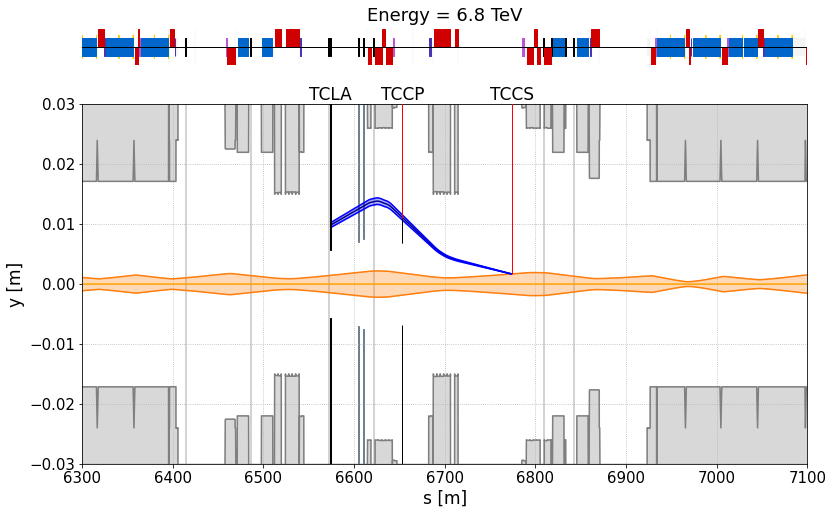

In [25]:
start, stop = 6300 , 7100
fig, ir3_plot = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(13,8))
pymadx.Plot._SetMachineAxesStyle(ir3_plot[0])
pymadx.Plot._DrawMachineLattice(ir3_plot[0], layout_data_object)
ir3_plot[0].set_xlim(start,stop)
ir3_plot[0].set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=18)
plot_IR3(ir3_plot[1], df_ref, df_chann_part, df_chann_part_upper, df_chann_part_lower, df_apertures, df_coll)


In [22]:
"""stop = line.element_names.index(TCLA_name)
start = line.element_names.index(TCCS_name)

for i in range(start, stop):
    if line[i].__class__.__name__.startswith('SRotation'):   #line.element_names[i].endswith('b2') and  'offset' in line.element_names[i] and
        print(line.element_names[i], '\t\t', end_s-line.get_s_elements()[i], '\t\t', line[i])"""

"stop = line.element_names.index(TCLA_name)\nstart = line.element_names.index(TCCS_name)\n\nfor i in range(start, stop):\n    if line[i].__class__.__name__.startswith('SRotation'):   #line.element_names[i].endswith('b2') and  'offset' in line.element_names[i] and\n        print(line.element_names[i], '\t\t', end_s-line.get_s_elements()[i], '\t\t', line[i])"

# Plots

In [ ]:
df_apertures = load_apertures(line_cry_b4_aperture)

In [ ]:
#df_apertures = pd.read_csv("./csv_pandas_dataframes/apertures.csv")

df_cry_opt = pd.read_csv("./csv_pandas_dataframes/450_twiss.csv")
df_cry_part_chann = pd.read_csv("./csv_pandas_dataframes/450_chann.csv")
df_cry_part_chann_upper = pd.read_csv("./csv_pandas_dataframes/450_chann_upper.csv")
df_cry_part_chann_lower = pd.read_csv("./csv_pandas_dataframes/450_chann_lower.csv")
df_coll_450 =  pd.read_csv("./csv_pandas_dataframes/450_collimators.csv")

df_cry_opt_1TeV = pd.read_csv("./csv_pandas_dataframes/1000_twiss.csv")
df_cry_part_chann_1TeV = pd.read_csv("./csv_pandas_dataframes/1000_chann.csv")
df_cry_part_chann_upper_1TeV = pd.read_csv("./csv_pandas_dataframes/1000_chann_upper.csv")
df_cry_part_chann_lower_1TeV = pd.read_csv("./csv_pandas_dataframes/1000_chann_lower.csv")
df_coll_1000 = pd.read_csv("./csv_pandas_dataframes/1000_collimators.csv")

df_cry_opt_6800GeV = pd.read_csv("./csv_pandas_dataframes/6800_twiss.csv")
df_cry_part_chann_6800GeV = pd.read_csv("./csv_pandas_dataframes/6800_chann.csv")
df_cry_part_chann_upper_6800GeV = pd.read_csv("./csv_pandas_dataframes/6800_chann_upper.csv")
df_cry_part_chann_lower_6800GeV= pd.read_csv("./csv_pandas_dataframes/6800_chann_lower.csv")
df_coll =  pd.read_csv("./csv_pandas_dataframes/6800_collimators.csv")

In [ ]:
# fig = plt.figure(figsize=(30,16))

# inj_plot = plt.subplot(2,2,1)
# OneTev_plot = plt.subplot(2,2,2)
# SixEightTev_plot = plt.subplot(2,2,3)

# plot_IR3(inj_plot, df_cry_opt, df_cry_part_chann, df_cry_part_chann_upper,df_cry_part_chann_lower,df_apertures)
# inj_plot.set_title(label='Energy = 450 GeV', y=1.05, fontsize=18)
# plot_IR3(OneTev_plot, df_cry_opt_1TeV, df_cry_part_chann_1TeV, df_cry_part_chann_upper_1TeV,df_cry_part_chann_lower_1TeV,df_apertures)
# OneTev_plot.set_title(label='Energy = 1 TeV', y=1.05, fontsize=18)
# plot_IR3(SixEightTev_plot, df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, df_cry_part_chann_upper_6800GeV,df_cry_part_chann_lower_6800GeV,df_apertures)
# SixEightTev_plot.set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=18)

# #text_b2 = r'$x$ = ' f'{x_b2:.3f} m' r'        $y$ = ' f'{y_b2:.3f} m' '\n' r"$p_x$ = " f'{px_b2:.3f} rad' r"    $p_y$ = " f'{py_b2:.5f} rad'

In [ ]:
TTCS_loc = end_s - 6773.7  #6775   6673.7
TTCP_loc = end_s - 6653.5 #6655    6653.3
#RP1_loc  = end_s - #6654
TCLA_loc  = end_s - 6574

In [ ]:
print()

In [ ]:
start = 6560
stop = 6720

fig, ir3_plot_6800GeV = plt.subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True, figsize=(25,14))
plot_IR3(ir3_plot_6800GeV[1], df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, df_cry_part_chann_upper_6800GeV,df_cry_part_chann_lower_6800GeV,df_apertures, df_coll, start, stop)
pymadx.Plot._SetMachineAxesStyle(ir3_plot_6800GeV[0])
DrawMachineLattice(ir3_plot_6800GeV[0], layout_data_object_6800)
ir3_plot_6800GeV[0].set_xlim(start,stop)
ir3_plot_6800GeV[0].set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=18)

In [ ]:
line_cry_b4_6800.get_s_position('tcla.a5l3.b2')

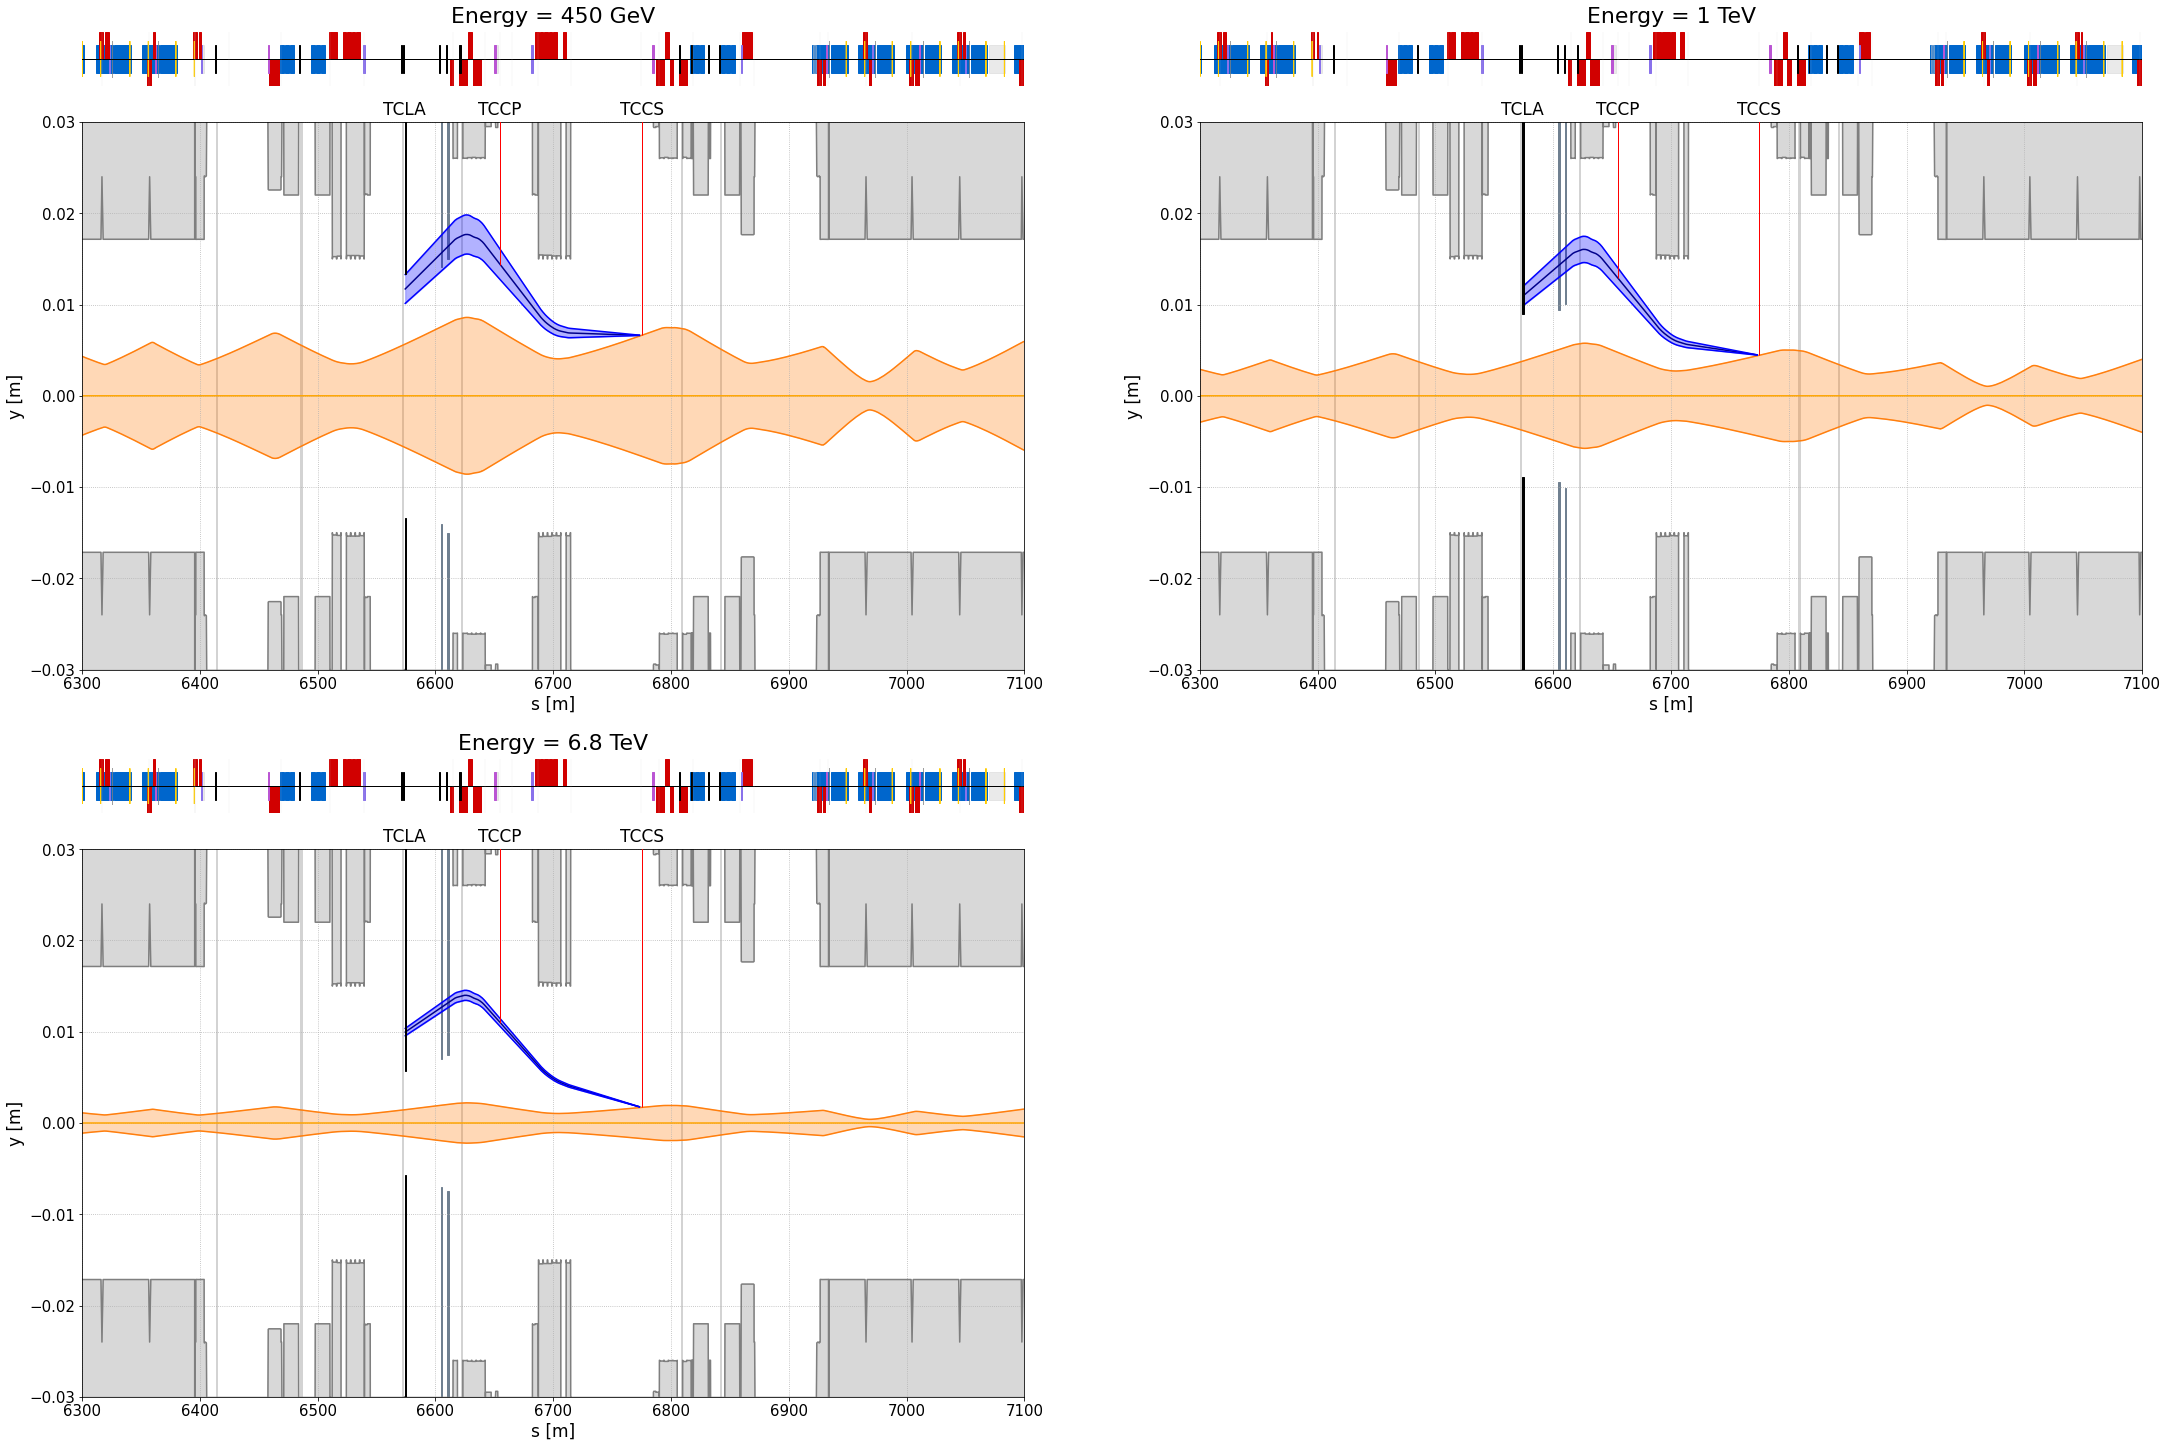

In [94]:
fig = plt.figure(layout='constrained', figsize=(30,20))
subfigs = fig.subfigures(2, 2, wspace=0.07)

inj_plot = subfigs[0][0].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
plot_IR3(inj_plot[1], df_cry_opt, df_cry_part_chann, df_cry_part_chann_upper,df_cry_part_chann_lower, df_apertures, df_coll_450)
pymadx.Plot._SetMachineAxesStyle(inj_plot[0])
DrawMachineLattice(inj_plot[0], layout_data_object)
inj_plot[0].set_xlim(6300,7100)
inj_plot[0].set_title(label='Energy = 450 GeV', y=1.05, fontsize=22)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

OneTev_plot = subfigs[0][1].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
plot_IR3(OneTev_plot[1], df_cry_opt_1TeV, df_cry_part_chann_1TeV, df_cry_part_chann_upper_1TeV,df_cry_part_chann_lower_1TeV, df_apertures, df_coll_1000)
pymadx.Plot._SetMachineAxesStyle(OneTev_plot[0])
DrawMachineLattice(OneTev_plot[0], layout_data_object)
OneTev_plot[0].set_xlim(6300,7100)
OneTev_plot[0].set_title(label='Energy = 1 TeV', y=1.05, fontsize=22)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)


SixEightTev_plot = subfigs[1][0].subplots(2, 1, gridspec_kw={'height_ratios': [0.1, 1]}, sharex=True)
plot_IR3(SixEightTev_plot[1], df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, df_cry_part_chann_upper_6800GeV,df_cry_part_chann_lower_6800GeV, df_apertures, df_coll_6800)
pymadx.Plot._SetMachineAxesStyle(SixEightTev_plot[0])
DrawMachineLattice(SixEightTev_plot[0], layout_data_object_6800)
SixEightTev_plot[0].set_xlim(6300,7100)
SixEightTev_plot[0].set_title(label='Energy = 6.8 TeV', y=1.05, fontsize=22)
#plt.subplots_adjust(left=0.125, bottom=0.1, right=0.9, top=0.9, wspace=0.1, hspace=0.1)

plt.savefig("IR3_channeling.pdf")
plt.savefig("IR3_channeling.jpg")

In [96]:
print('Sigma CRY2 at 450 GeV = ', calc_nsigma_cry2(df_cry_opt, df_cry_part_chann, 450e9))
print('Sigma CRY2 at 1000 GeV = ', calc_nsigma_cry2(df_cry_opt_1TeV, df_cry_part_chann_1TeV, 1000e9))
print('Sigma CRY2 at 6800 GeV = ', calc_nsigma_cry2(df_cry_opt_6800GeV, df_cry_part_chann_6800GeV, 6800e9))

NameError: name 'calc_nsigma_cry2' is not defined

In [46]:

import IPython

IPython.Application.instance().kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

: 